In [1]:
import os
import time
import numpy as np
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nfl-playoffs-19702021/df_kaggle_test.csv
/kaggle/input/nfl-playoffs-19702021/playoffs.csv
/kaggle/input/nfl-playoffs-19702021/all_games.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_test_labels.csv
/kaggle/input/nfl-playoffs-19702021/df_kaggle_train.csv
/kaggle/input/nfl-playoffs-19702021/games_calculated_averages.csv
/kaggle/input/nfl-playoffs-19702021/1970-2021.csv
/kaggle/input/nfl-playoffs-19702021/regular_season.csv
/kaggle/input/nfl-playoffs-19702021/1970-2021_team_schedule.csv
/kaggle/input/nfl-playoffs-19702021/df_only_averages.csv
/kaggle/input/nfl-playoffs-19702021/grouped_averages.csv


In [4]:
class Timer:
    
    def __init__(self):
        self.start_time = time.time()
        
    def end(self):
        self.end_time = time.time()
        elapsed_time = round(self.end_time - self.start_time, 3)
        print(f'Execution took {elapsed_time}s')

---

In [5]:
from pprint import pprint
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    accuracy_score,
    balanced_accuracy_score,
    precision_score, 
    recall_score, 
    f1_score
)
from datetime import datetime

all_scores = {}

def show_scores(scores: dict = all_scores):
    display(pd.DataFrame(all_scores.values()))

def calculate_scores(
    model_name: str, 
    y_test: pd.Series, pred: np.ndarray, 
    pos_label: str or int = 1,
    score_list: list = all_scores,
    display_confusion_matrix: bool = True,
    display_scores: bool = True
    ):
    cf_mx = ConfusionMatrixDisplay.from_predictions(y_test, pred)
    acc = accuracy_score(y_test, pred)
    bacc = balanced_accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, pos_label=pos_label)
    recall = recall_score(y_test, pred, pos_label=pos_label)
    f1 = f1_score(y_test, pred, pos_label=pos_label)
    
    model_scores = {
        'model_name': model_name,
        'acc': acc,
        'bacc': bacc,
        'precision': precision,
        'recall': recall,
        'f1score': f1
    }
    score_list[model_name] = model_scores
    
    if display_confusion_matrix:
        display(cf_mx)   
    if show_scores:
        show_scores(score_list)
    return model_scores

In [6]:
from joblib import dump

def save_clf(clf, clf_name: str):
    dump(clf, clf_name + '.joblib')

---

# Carregamento do dataset Kaggle e preparaçao para treino e teste

In [7]:
df_averages = pd.read_csv('/kaggle/input/nfl-playoffs-19702021/df_only_averages.csv')
df_averages.drop(['Unnamed: 0'], axis=1, inplace=True)
df_averages.sort_values(['gs_year'], ascending=False, inplace=True)

In [8]:
df_averages.drop(df_averages[pd.isna(df_averages['gs_is_playoff'])].index, inplace=True)
df_averages.drop(df_averages[pd.isna(df_averages['winorlose'])].index, inplace=True)
df_averages.drop(df_averages[df_averages['winorlose'] == 'T'].index, inplace=True)

In [9]:
df_averages.shape

(12542, 35)

---

In [10]:
df_train = df_averages[df_averages['gs_year'] < 2019].copy()
df_train

,gs_year,gs_team,winorlose,gs_id,gs_is_playoff,avg_gs_pts_off,avg_gs_pts_def,avg_gs_first_down_off,avg_gs_yards_off,avg_gs_pass_yds_off,avg_gs_rush_yds_off,avg_gs_to_off,avg_gs_first_down_def,avg_gs_yards_def,avg_gs_pass_yds_def,avg_gs_rush_yds_def,avg_gs_to_def,avg_gs_exp_pts_off,avg_gs_exp_pts_def,avg_gs_exp_pts_st,last_year_avg_gs_pts_off,last_year_avg_gs_pts_def,last_year_avg_gs_first_down_off,last_year_avg_gs_yards_off,last_year_avg_gs_pass_yds_off,last_year_avg_gs_rush_yds_off,last_year_avg_gs_to_off,last_year_avg_gs_first_down_def,last_year_avg_gs_yards_def,last_year_avg_gs_pass_yds_def,last_year_avg_gs_rush_yds_def,last_year_avg_gs_to_def,last_year_avg_gs_exp_pts_off,last_year_avg_gs_exp_pts_def,last_year_avg_gs_exp_pts_st
11598,2018,Ravens,W,602.0,False,23.000000,34.000000,28.000000,425.000000,359.000000,66.000000,3.000000,24.000000,373.000000,265.000000,108.000000,NaN,2.720000,-12.800000,1.120000,18.669048,17.740476,16.626531,264.080612,135.184694,128.895918,1.764286,17.192517,293.688776,182.507143,111.181633,3.219048,-5.338942,8.586643,0.100163
11592,2018,Colts,W,763.0,False,23.750000,27.250000,20.250000,339.250000,243.500000,95.750000,3.000000,22.500000,381.250000,276.000000,105.250000,1.750000,-1.150000,-3.530000,3.207500,15.400680,38.341497,14.532313,264.014966,171.928231,92.086735,2.026190,20.432993,396.807143,281.085034,115.722109,1.376190,-14.018493,-11.140231,3.264252
11593,2018,Browns,L,693.0,False,27.666667,30.666667,18.000000,373.000000,233.000000,140.000000,2.000000,26.333333,432.000000,327.000000,105.000000,2.666667,-1.253333,-3.186667,-0.550000,17.001701,28.651020,20.941156,352.614966,232.391497,120.223469,3.595238,20.094558,342.084014,223.086395,118.997619,1.404762,-6.523313,-5.998888,0.626361
11594,2018,Dolphins,L,642.0,False,14.666667,25.666667,15.333333,242.000000,135.666667,106.333333,2.333333,21.333333,381.000000,274.333333,106.666667,2.000000,-9.650000,-4.286667,3.930000,14.132313,23.155102,18.281633,281.719728,195.068027,86.651701,1.744444,21.276190,362.352041,255.690476,106.661565,1.111111,-4.648224,-9.038235,4.205915
11595,2018,Packers,W,956.0,False,20.285714,28.142857,19.142857,360.428571,269.142857,91.285714,1.333333,21.857143,375.000000,249.000000,126.000000,1.000000,6.405714,-9.942857,-5.991429,24.262245,28.792517,21.360204,331.571429,232.677211,98.894218,2.000000,21.601701,374.296599,243.622109,130.674490,2.358333,7.406837,-10.109241,-1.312935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1970,49ers,W,26597.0,False,25.666667,14.333333,16.333333,318.666667,232.000000,86.666667,1.666667,13.333333,246.333333,130.666667,115.666667,2.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,1970,Browns,L,26392.0,False,26.333333,19.000000,17.666667,342.333333,229.333333,113.000000,3.333333,17.666667,298.000000,152.333333,145.666667,2.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,1970,Chiefs,W,26434.0,False,23.500000,24.000000,11.750000,227.000000,122.000000,105.000000,4.333333,18.750000,256.250000,147.500000,108.750000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,1970,Chargers,W,26448.0,False,19.000000,18.000000,16.000000,275.000000,185.666667,89.333333,4.000000,15.333333,267.666667,130.000000,137.666667,2.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_test = df_averages[df_averages['gs_year'] >= 2019].copy()
df_test

,gs_year,gs_team,winorlose,gs_id,gs_is_playoff,avg_gs_pts_off,avg_gs_pts_def,avg_gs_first_down_off,avg_gs_yards_off,avg_gs_pass_yds_off,avg_gs_rush_yds_off,avg_gs_to_off,avg_gs_first_down_def,avg_gs_yards_def,avg_gs_pass_yds_def,avg_gs_rush_yds_def,avg_gs_to_def,avg_gs_exp_pts_off,avg_gs_exp_pts_def,avg_gs_exp_pts_st,last_year_avg_gs_pts_off,last_year_avg_gs_pts_def,last_year_avg_gs_first_down_off,last_year_avg_gs_yards_off,last_year_avg_gs_pass_yds_off,last_year_avg_gs_rush_yds_off,last_year_avg_gs_to_off,last_year_avg_gs_first_down_def,last_year_avg_gs_yards_def,last_year_avg_gs_pass_yds_def,last_year_avg_gs_rush_yds_def,last_year_avg_gs_to_def,last_year_avg_gs_exp_pts_off,last_year_avg_gs_exp_pts_def,last_year_avg_gs_exp_pts_st
12389,2021,Jaguars,L,4258.0,False,16.500000,28.750000,19.000000,344.000000,225.000000,119.000000,1.666667,18.750000,348.250000,239.750000,108.500000,NaN,-0.080000,-9.585000,-1.885000,24.936054,32.405102,24.259184,405.762925,282.811565,122.951361,1.659184,24.806122,430.098980,287.623469,142.475510,1.502778,9.008071,-17.787109,-1.036636
12456,2021,Lions,L,4472.0,False,14.875000,24.125000,18.500000,325.375000,189.375000,136.000000,1.857143,21.000000,350.250000,223.875000,126.375000,1.80,-1.383750,-9.737500,2.372500,23.648299,29.647279,21.341156,339.998639,239.123469,100.875170,1.223810,24.337415,411.503401,248.730612,162.772789,2.216667,6.329017,-13.885381,2.658422
12403,2021,Ravens,L,4203.0,False,19.000000,18.666667,20.500000,354.666667,232.833333,121.833333,1.400000,18.500000,342.333333,256.000000,86.333333,1.00,0.085000,-1.705000,1.556667,29.237654,18.789947,19.633995,358.694885,177.504453,181.190432,1.570833,20.758333,330.733333,230.891358,99.841975,1.556085,7.997661,0.580535,2.979090
12404,2021,Jaguars,L,4259.0,False,14.600000,30.400000,18.000000,314.600000,207.200000,107.400000,1.750000,19.800000,362.200000,249.800000,112.400000,NaN,-2.574000,-11.906000,-0.858000,24.936054,32.405102,24.259184,405.762925,282.811565,122.951361,1.659184,24.806122,430.098980,287.623469,142.475510,1.502778,9.008071,-17.787109,-1.036636
12405,2021,Raiders,L,4335.0,False,25.200000,25.000000,20.600000,395.200000,306.000000,89.200000,2.000000,21.200000,363.200000,256.800000,106.400000,2.00,7.634000,-5.264000,-1.774000,28.280272,29.316327,21.793537,376.168027,238.189116,137.978912,2.261111,22.034694,377.921769,230.754422,147.167347,1.055556,11.926303,-11.763793,-0.680874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11952,2019,Packers,W,394.0,False,20.833333,21.166667,18.166667,271.000000,183.333333,87.666667,1.000000,21.500000,378.333333,274.666667,103.666667,2.00,2.111667,-5.378333,3.073333,20.436054,29.944218,20.775170,384.315986,286.815646,97.500340,1.485714,21.167687,367.664286,231.707143,135.957143,1.000000,6.836959,-10.114503,-7.588871
11954,2019,Giants,W,323.0,False,21.000000,29.714286,16.571429,316.571429,236.571429,80.000000,2.000000,22.285714,406.000000,311.000000,95.000000,1.60,-2.704286,-7.345714,0.335714,21.723469,23.168027,18.585374,341.264966,270.670408,70.594558,1.595238,19.202721,356.264626,249.674830,106.589796,1.861111,6.024588,-6.198782,-1.131888
11955,2019,Cowboys,L,306.0,False,24.000000,20.857143,22.000000,399.571429,281.714286,117.857143,1.600000,19.571429,307.142857,208.142857,99.000000,1.75,10.301429,-1.997143,-4.680000,13.723661,19.628274,17.342857,290.433036,174.583185,115.849851,1.808333,20.129911,338.839732,218.693601,120.146131,1.264583,-5.387631,-1.868781,1.745897
11956,2019,Raiders,W,272.0,False,17.500000,33.500000,17.166667,346.833333,227.833333,119.000000,1.800000,23.166667,376.666667,265.666667,111.000000,1.50,1.756667,-16.121667,-0.270000,16.227891,25.172109,19.395238,349.024490,257.261224,91.763265,1.902778,17.616327,380.671088,255.863265,124.807823,1.238095,3.500986,-11.845639,-2.599452


In [12]:
df_train.shape, df_test.shape

((11721, 35), (821, 35))

---

# Pre-processamento

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
target = 'winorlose'

In [15]:
# bool to numeric
non_numeric_or_object = df_train.select_dtypes(exclude=[np.number, object]).columns
df_train[non_numeric_or_object] = df_train[non_numeric_or_object].astype(int)

non_numeric_or_object = df_test.select_dtypes(exclude=[np.number, object]).columns
df_test[non_numeric_or_object] = df_test[non_numeric_or_object].astype(int)

df_train['gs_is_playoff'] = df_train['gs_is_playoff'].astype(int)
df_test['gs_is_playoff'] = df_test['gs_is_playoff'].astype(int)

In [16]:
# target encoding
target_encoder = {'L': 0, 'W': 1}
df_train[target] = df_train[target].map(target_encoder)
df_test[target] = df_test[target].map(target_encoder)

# col names
cat_cols = df_train.select_dtypes(object).columns.tolist()
num_cols = df_train.select_dtypes(np.number).columns.tolist()

In [17]:
# dealing with nans (I hope)
df_train.fillna(-1, inplace=True)
df_test.fillna(-1, inplace=True)

In [18]:
x_final = df_train.copy().drop(target, axis=1)
y_final = df_train[target]

df_test_final = df_test.copy().drop(target, axis=1)
df_test_labels = df_test[target]

In [19]:
x_final.shape, y_final.shape, df_test_final.shape, df_test_labels.shape

((11721, 34), (11721,), (821, 34), (821,))

In [20]:
(~np.isfinite(x_final.select_dtypes(np.number))).sum()

gs_year                            0
gs_id                              0
gs_is_playoff                      0
avg_gs_pts_off                     0
avg_gs_pts_def                     0
avg_gs_first_down_off              0
avg_gs_yards_off                   0
avg_gs_pass_yds_off                0
avg_gs_rush_yds_off                0
avg_gs_to_off                      0
avg_gs_first_down_def              0
avg_gs_yards_def                   0
avg_gs_pass_yds_def                0
avg_gs_rush_yds_def                0
avg_gs_to_def                      0
avg_gs_exp_pts_off                 0
avg_gs_exp_pts_def                 0
avg_gs_exp_pts_st                  0
last_year_avg_gs_pts_off           0
last_year_avg_gs_pts_def           0
last_year_avg_gs_first_down_off    0
last_year_avg_gs_yards_off         0
last_year_avg_gs_pass_yds_off      0
last_year_avg_gs_rush_yds_off      0
last_year_avg_gs_to_off            0
last_year_avg_gs_first_down_def    0
last_year_avg_gs_yards_def         0
l

---

# Pipeline pre-processamento

In [21]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

In [22]:
preprocess_pipeline = make_column_transformer(
    (SimpleImputer(strategy='mean', fill_value='constant'), make_column_selector(dtype_include=np.number)),
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include=object))
)

# Classificadores

In [23]:
RANDOM_STATE = 22

## Gaussian Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [25]:
clf_gaussian_nb = GaussianNB()

## Multi-layer perceptron

In [26]:
from sklearn.neural_network import MLPClassifier

In [27]:
clf_mlp = MLPClassifier(
    max_iter=2000, 
    n_iter_no_change=50, 
    warm_start=True, 
    random_state=RANDOM_STATE
)

## Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
clf_rfc = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=1,
    max_features='auto',
    max_depth=100,
    bootstrap=False,
    warm_start=True,
    random_state=RANDOM_STATE
)

# Combinando os classificadores

In [30]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [31]:
def make_new_stacking_pipeline():
    stacking_clf = StackingClassifier(
        estimators=[
            ('gaussian_nb', clf_gaussian_nb),
            ('mlp', clf_mlp),
            # ('keras', clf_keras)
            ('rfc', clf_rfc)
        ],
        final_estimator=LogisticRegression(max_iter=1000)
    )
    pipeline = make_pipeline(
        preprocess_pipeline,
        RobustScaler(),
        stacking_clf
    )

    return pipeline

## Treino 1970-2018, teste com 2019-2021

In [32]:
stack_pipeline = make_new_stacking_pipeline()
stack_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value='constant'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f35dab2b4d0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector ob...
                ('stackingclassifier',
                 StackingClassifier(estimators=[('gaussian_nb', GaussianNB()),
                                                ('mlp',
                                                 MLPClassifier(max_iter=2000,
                                                    

In [33]:
train_timer = Timer()

# stack_pipeline.fit(x_final, y_final)

train_timer.end()

Execution took 0.0s


In [34]:
# preds = stack_pipeline.predict(df_test_final)

# scores = calculate_scores('stacking_train_1970-2019', df_test_labels, preds)

# Keras

É o que sobrou

## 1970-2018, 2019-2021 

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from tqdm.keras import TqdmCallback

In [36]:
def build_keras_model():
    clf = Sequential()
    clf.add(Dense(64, input_dim = x_final.shape[1], activation='relu'))

    clf.add(Dense(32, activation='relu'))
    clf.add(Dense(16, activation='relu'))
    clf.add(Dense(8, activation='relu'))
#     clf.add(Dense(128, activation='relu'))

    clf.add(Dense(1, activation='sigmoid'))

    clf.compile(
        loss='binary_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
        )

    return clf

In [37]:
clf_keras = KerasClassifier(
    build_fn=build_keras_model, 
    epochs=500,
    batch_size=64, 
    verbose=0
)
clf_keras._estimator_type = "classifier"

keras_pipeline = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    clf_keras
)

In [38]:
fit_params = {
    'kerasclassifier__callbacks': [TqdmCallback(verbose=1)]
}

train_timer = Timer()

keras_pipeline.fit(x_final, y_final, **fit_params)

train_timer.end()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-09-02 19:56:21.212432: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-02 19:56:21.377899: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Execution took 240.509s


,model_name,acc,bacc,precision,recall,f1score
0,keras_train_1970-2019,0.509135,0.507785,0.495913,0.455,0.474576


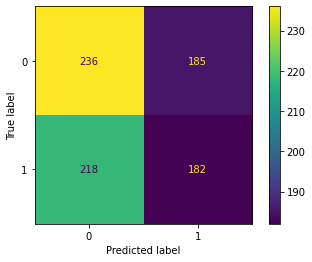

In [39]:
keras_preds = keras_pipeline.predict(df_test_final)

keras_scores = calculate_scores('keras_train_1970-2019', df_test_labels, keras_preds)

## 2010-2018, 2019-2021 

In [40]:
clf_keras = KerasClassifier(
    build_fn=build_keras_model, 
    epochs=200,
    batch_size=64, 
    verbose=0
)
clf_keras._estimator_type = "classifier"

fit_params = {
    'kerasclassifier__callbacks': [TqdmCallback(verbose=1)]
}

keras_pipeline = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    clf_keras
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [41]:
x2010 = x_final[x_final['gs_year'] >= 2010]
y2010 = y_final.filter(x2010.index, axis=0)

x2010.shape, y2010.shape

((2405, 34), (2405,))

In [42]:
train_timer = Timer()

keras_pipeline.fit(x2010, y2010, **fit_params)

train_timer.end()

Execution took 20.69s


,model_name,acc,bacc,precision,recall,f1score
0,keras_train_1970-2019,0.509135,0.507785,0.495913,0.455,0.474576
1,keras_train_2010-2019,0.511571,0.507417,0.498195,0.345,0.407681


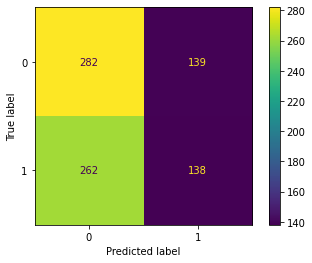

In [43]:
keras_preds = keras_pipeline.predict(df_test_final)

keras_scores = calculate_scores('keras_train_2010-2019', df_test_labels, keras_preds)

## 2000-2018, 2019-2021 

In [44]:
clf_keras = KerasClassifier(
    build_fn=build_keras_model, 
    epochs=200,
    batch_size=64, 
    verbose=0
)
clf_keras._estimator_type = "classifier"

fit_params = {
    'kerasclassifier__callbacks': [TqdmCallback(verbose=1)]
}

keras_pipeline = make_pipeline(
    preprocess_pipeline,
    RobustScaler(),
    clf_keras
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [45]:
x2000 = x_final[x_final['gs_year'] >= 2000]
y2000 = y_final.filter(x2000.index, axis=0)

x2000.shape, y2000.shape

((5067, 34), (5067,))

In [46]:
train_timer = Timer()

keras_pipeline.fit(x2000, y2000, **fit_params)

train_timer.end()

Execution took 42.875s


,model_name,acc,bacc,precision,recall,f1score
0,keras_train_1970-2019,0.509135,0.507785,0.495913,0.4550,0.474576
1,keras_train_2010-2019,0.511571,0.507417,0.498195,0.3450,0.407681
2,keras_train_2000-2019,0.485993,0.484783,0.470430,0.4375,0.453368


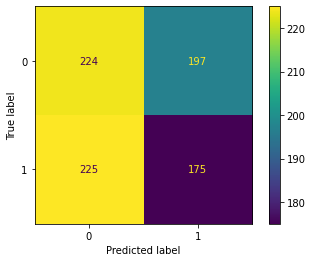

In [47]:
keras_preds = keras_pipeline.predict(df_test_final)

keras_scores = calculate_scores('keras_train_2000-2019', df_test_labels, keras_preds)